# Light Gradient Boosting Machine (LightGBM) Model


In [1]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('data.xlsx', index_col='Date', parse_dates=True)
df = df.asfreq('h')

In [4]:
# create lag features
df['relative_humidity_2m (%)_lag3'] = df['relative_humidity_2m (%)'].shift(3)
df['wind_speed_10m (km/h)_lag6'] = df['wind_speed_10m (km/h)'].shift(6)
df['soil_moisture_0_to_7cm (m³/m³)_lag72'] = df['soil_moisture_0_to_7cm (m³/m³)'].shift(72)
df['direct_radiation (W/m²)_lag72'] = df['direct_radiation (W/m²)'].shift(72)

In [5]:
df = df.dropna()

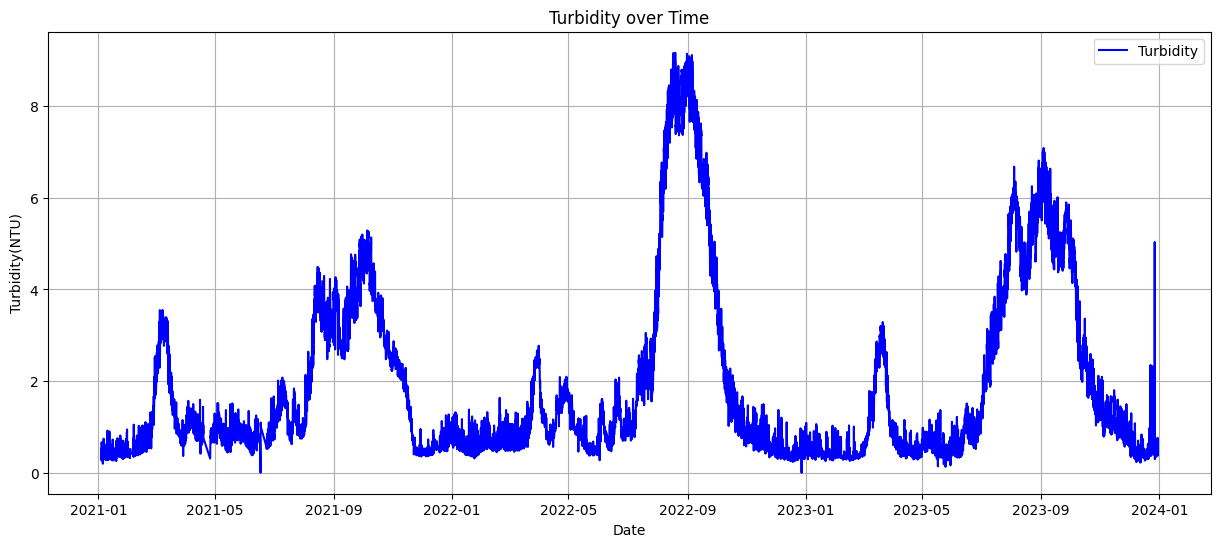

In [6]:
plt.figure(figsize=(15,6))
plt.plot(df.index, df['turbidity'], label='Turbidity', color='blue')
plt.xlabel('Date')
plt.ylabel('Turbidity(NTU)')
plt.title('Turbidity over Time')
plt.legend()
plt.grid()
plt.show()

In [7]:
feature_colums = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'wind_speed_10m (km/h)', 'soil_moisture_0_to_7cm (m³/m³)', 'direct_radiation (W/m²)', 'relative_humidity_2m (%)_lag3', 'wind_speed_10m (km/h)_lag6', 'soil_moisture_0_to_7cm (m³/m³)_lag72', 'direct_radiation (W/m²)_lag72']
target_column = 'turbidity'
X = df[feature_colums]
y = df[target_column]


In [8]:
# split the data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [10]:
# Define the model
model = LGBMRegressor()


In [11]:
# Define parameters for GridSearchCV
param_grid = {
    'num_leaves': [30, 50, 70, 100],
    'max_depth': [-1, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200]
}



In [12]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)


In [13]:
# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

In [14]:
# Fit the model
grid_search.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1917
[LightGBM] [Info] Number of data points in the train set: 20943, number of used features: 9
[LightGBM] [Info] Start training from score 1.633114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [-1, 5, 10, 20],
                         'n_estimators': [100, 200],
                         'num_leaves': [30, 50, 70, 100]},
             scoring='neg_mean_squared_error')

In [15]:
# Best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 50}


In [16]:
# Best model
best_model = grid_search.best_estimator_

In [17]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)





In [18]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

MAE: 1.5147
MSE: 3.9529
RMSE: 1.9882
R²: 0.0449
MAPE: 0.8697


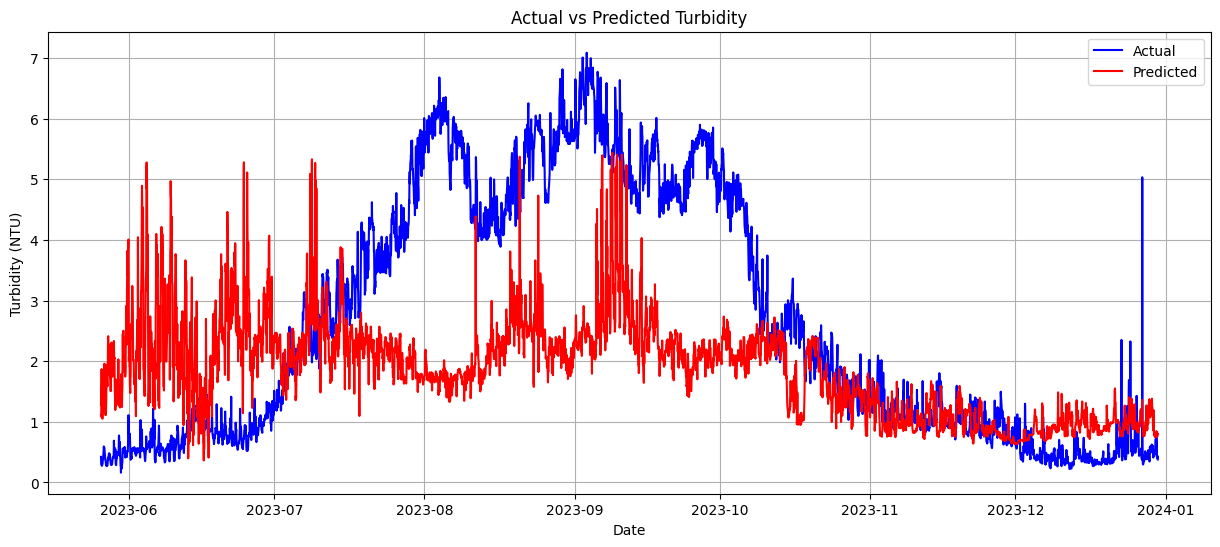

In [19]:
# Plotting the predictions vs actual values
plt.figure(figsize=(15,6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Turbidity (NTU)')
plt.title('Actual vs Predicted Turbidity')
plt.legend()
plt.grid()
plt.show()

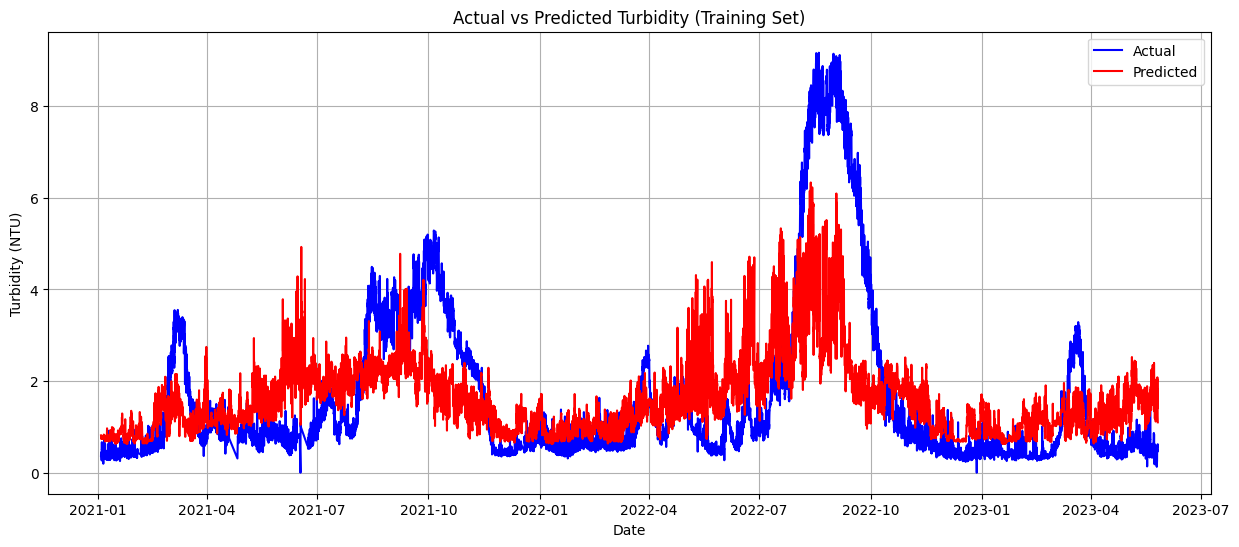

In [20]:
# make preidctions on the training set
y_train_pred = best_model.predict(X_train)
# Plotting the predictions vs actual values for training set
plt.figure(figsize=(15,6))
plt.plot(y_train.index, y_train, label='Actual', color='blue')
plt.plot(y_train.index, y_train_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Turbidity (NTU)')
plt.title('Actual vs Predicted Turbidity (Training Set)')
plt.legend()
plt.grid()
plt.show()


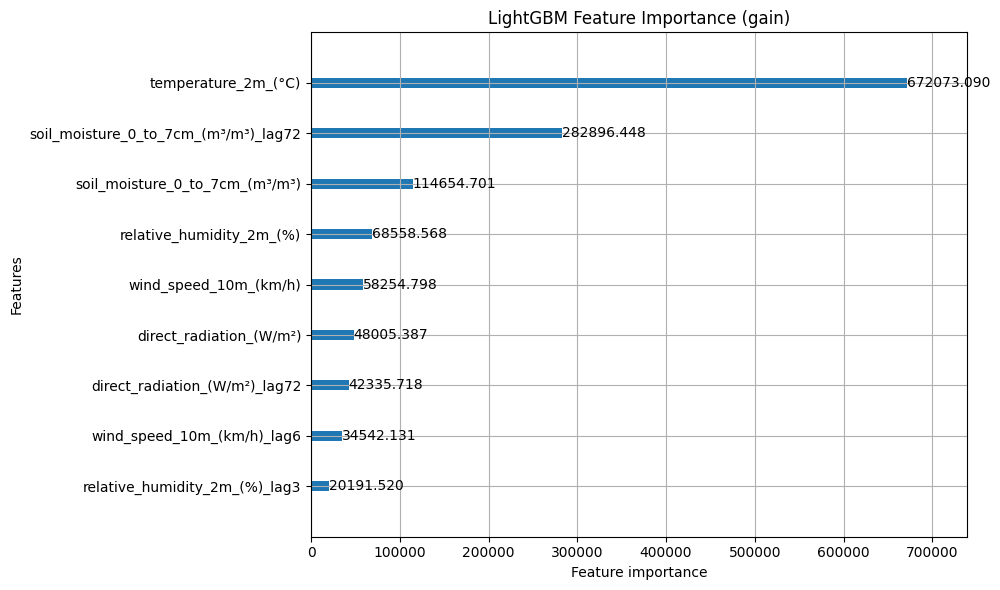

In [21]:
# PLot feature importance
import lightgbm as lgb
import matplotlib.pyplot as plt

# Assuming best_model is your trained model
lgb.plot_importance(best_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title('LightGBM Feature Importance (gain)')
plt.tight_layout()
plt.show()


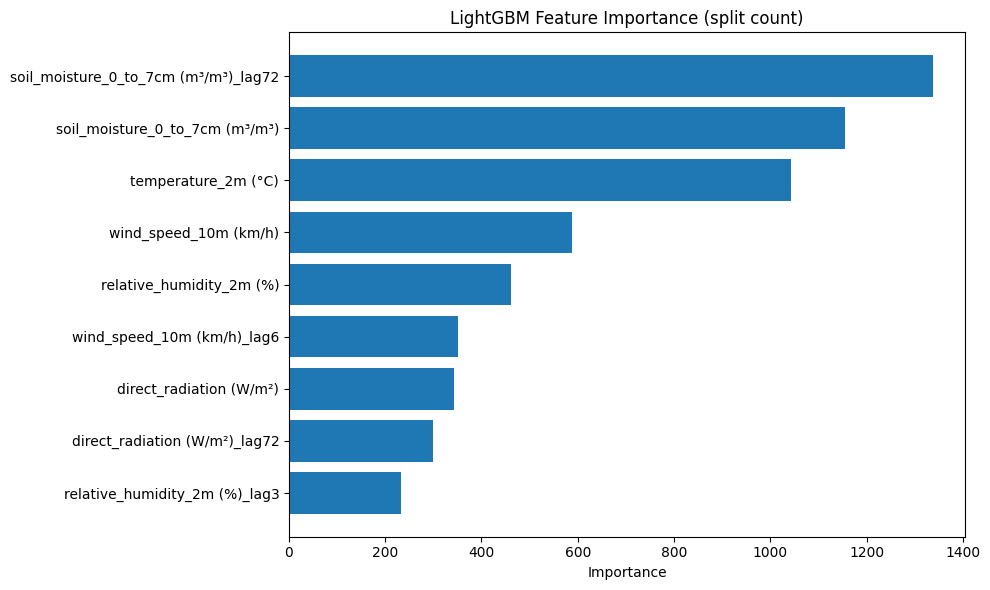

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model.feature_importances_
feature_names = df[feature_colums].columns

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('LightGBM Feature Importance (split count)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
